In [35]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
from opentn.states.qubits import up, down
from opentn.transformations import exp_operator_dt, create_2local_liouvillians
sigma_plus = np.outer(down, up)
sigma_minus = np.outer(up, down)

tau = 1
lambda_zero = 1
nu = 0.5

L1 = np.sqrt(lambda_zero * (nu + 1)) * sigma_minus
L2 = np.sqrt(lambda_zero * nu) * sigma_plus
lindbladians = [L1, L2]

N = 1
d = 2

# this would create odd = full, and even is empty
Lvec, Lvec_odd, Lvec_even = create_2local_liouvillians(Li=lindbladians, N=N, d=d, pbc=False)
exp_Lvec = exp_operator_dt(Lvec, tau, "jax")

In [66]:
from opentn.transformations import dissipative2liouvillian_full, op2fullspace

op = L2
print(np.allclose(op, op2fullspace(op=op, i=0, N=1, num_sites=1)))



Lvec_test = dissipative2liouvillian_full(L=L1, i=0, N=1, num_sites=1)
Lvec_test += dissipative2liouvillian_full(L=L2, i=0, N=1, num_sites=1)
np.allclose(Lvec_test, Lvec)

True


True

In [105]:
from opentn.structure_preserving import composition, unnormalized_scheme
start_timesteps_scheme = 10
num_timesteps_scheme = 100
superop_ord_1_ts = [composition(unnormalized_scheme(lindbladians=lindbladians, N=N, d=d, dt=tau/n, order=1, pbc=False), n=n) for n in range(start_timesteps_scheme, num_timesteps_scheme + 1)]
superop_ord_2_ts = [composition(unnormalized_scheme(lindbladians=lindbladians, N=N, d=d, dt=tau/n, order=2, pbc=False), n=n) for n in range(start_timesteps_scheme, num_timesteps_scheme + 1)]
# superop_ord_3_ts = [composition(unnormalized_scheme(lindbladians=lindbladians, N=N, d=d, dt=tau/n, order=3, verbose=True), n=n) for n in range(1, num_timesteps_scheme + 1)]

In [103]:
from opentn.optimization import get_general_trotter_local_ansatz, model_stiefel_local
from opentn.transformations import compose_superops_list, super2ortho

# superop_nonopt_ts = []
# for n in range(1, num_timesteps_scheme + 1):
#     xs_trotter_ts = [super2ortho(op) for op in get_general_trotter_local_ansatz(lindbladians=lindbladians, tau=tau, n=n)]
#     superop_nonopt_ts.append(model_stiefel_local(xs_trotter_ts, N, d))

# superop_nonopt_ts = [compose_superops_list(get_general_trotter_local_ansatz(lindbladians=lindbladians, tau=tau, n=n)) for n in range(1, num_timesteps_scheme + 1)]

compose_superops_list(get_general_trotter_local_ansatz(lindbladians=lindbladians, tau=tau, n=1))

DeviceArray([[0.75457893+0.j, 0.        +0.j, 0.        +0.j,
              0.7362633 +0.j],
             [0.        +0.j, 0.13533527+0.j, 0.        +0.j,
              0.        +0.j],
             [0.        +0.j, 0.        +0.j, 0.13533527+0.j,
              0.        +0.j],
             [0.24542107+0.j, 0.        +0.j, 0.        +0.j,
              0.2637367 +0.j]], dtype=complex128)

In [104]:
compose_superops_list(get_general_trotter_local_ansatz(lindbladians=lindbladians, tau=tau, n=2))

DeviceArray([[0.75457893+0.j, 0.        +0.j, 0.        +0.j,
              0.7362633 +0.j],
             [0.        +0.j, 0.13533527+0.j, 0.        +0.j,
              0.        +0.j],
             [0.        +0.j, 0.        +0.j, 0.13533527+0.j,
              0.        +0.j],
             [0.24542107+0.j, 0.        +0.j, 0.        +0.j,
              0.2637367 +0.j]], dtype=complex128)

In [106]:
from opentn.structure_preserving import random_psd_error
error_order_1_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error= superop_ord_1_ts, normalize=False, iterations=20)
error_order_2_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error= superop_ord_2_ts, normalize=False, iterations=20)
# error_order_3_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_ord_3_ts_0 +  superop_ord_3_ts, normalize=False)

In [93]:
# error_nonopt_unnorm = random_psd_error(superop_exact=exp_Lvec, superops_error=superop_nonopt_ts, normalize=False)

In [107]:
errors_unnorm = [error_order_1_unnorm, error_order_2_unnorm]

In [108]:
error_order_1_norm = random_psd_error(superop_exact=exp_Lvec, superops_error= superop_ord_1_ts, normalize=True, iterations=20)
error_order_2_norm = random_psd_error(superop_exact=exp_Lvec, superops_error= superop_ord_2_ts, normalize=True, iterations=20)

In [109]:
errors_norm = [error_order_1_norm, error_order_2_norm]

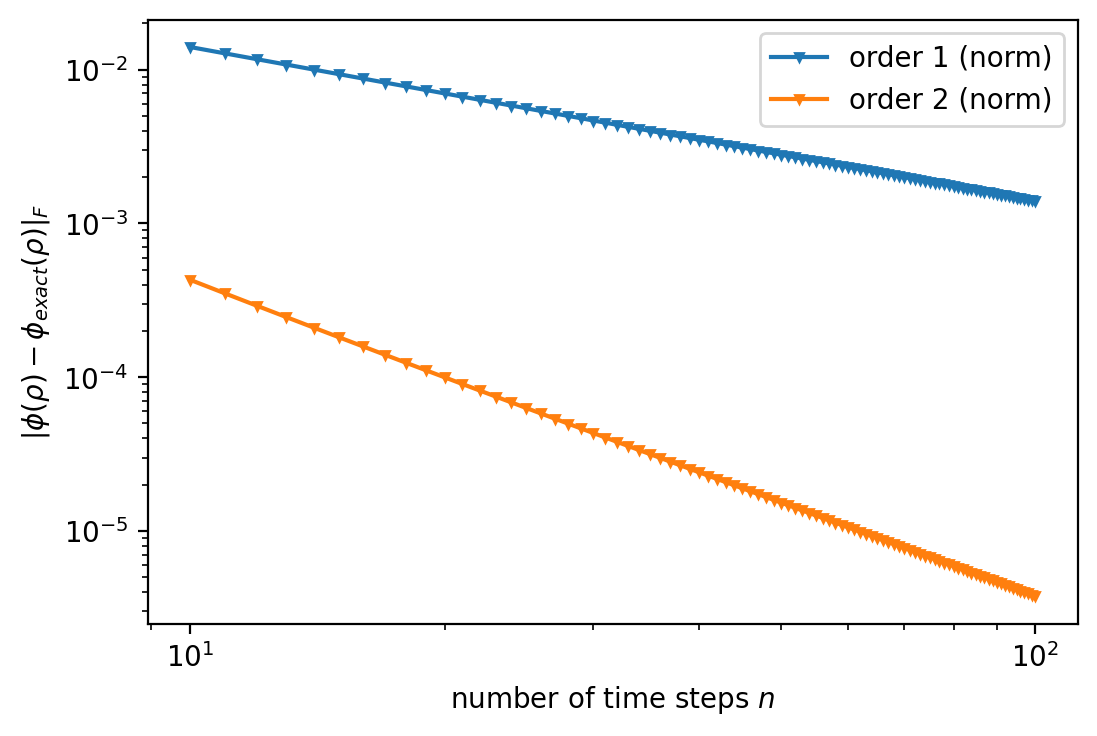

In [111]:
idx = 0
labels = ['order 1', 'order 2'][idx:]
fig = plt.figure(dpi=200)
plt.ylabel(r'$ \left| \phi(\rho) - \phi_{exact}(\rho) \right|_F $')
plt.xlabel('number of time steps $n$')
for i, (unnorm, norm) in enumerate(zip(errors_unnorm[idx:], errors_norm[idx:])):
    # plt.loglog(unnorm, '--', label=labels[i] + '(unnorm)')
    plt.loglog(range(start_timesteps_scheme, num_timesteps_scheme+1),norm[:], '-v', label=labels[i] + ' (norm)', markersize=3)
plt.legend()